# ECG Ventricular Flutter & Fibrillation Classification

In [1]:
import wfdb
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

## Path Configuration for ECG Data Categories

- Defining Paths for Different Categories of ECG Data

In [2]:
VFL_VF_path = "../data/1_Dangerous_VFL_VF/frag/"
VTTdP_path = "../data/2_Special_Form_VTTdP/frag/"
VT_path = "../data/3_Threatening_VT/frag/"
PD_path = "../data/4_Potential_Dangerous/frag/"
SP_path = "../data/5_Supraventricular/frag/"
SR_path = "../data/6_Sinus_rhythm/frag/"

paths = [VFL_VF_path, VTTdP_path, VT_path, PD_path, SP_path, SR_path]

## Comparative Visualization of Normal and Ventricular Flutter ECG Signals

- This part of the code only serves for understanding the task and visualizing the difference between the ECG signals 

### Loading and Extracting Data from Ventricular Flutter and Normal ECG Signals

In [3]:
# Loading frag of a VL signal and normal signal using wfdb library
record = wfdb.rdrecord("../data/1_Dangerous_VFL_VF/frag/422_C_VF_951s_frag")
record_normal = wfdb.rdrecord(SR_path+'/420_C_N_44_5s_frag')

# Extract the signal data
signal_data = record.p_signal  # This gives the raw ECG data
signal_data_normal = record_normal.p_signal


# Extract metadata of signal
sample_rate = record.fs  # Sampling frequency

### Visualization of Ventricular Flutter vs. Normal ECG Signals

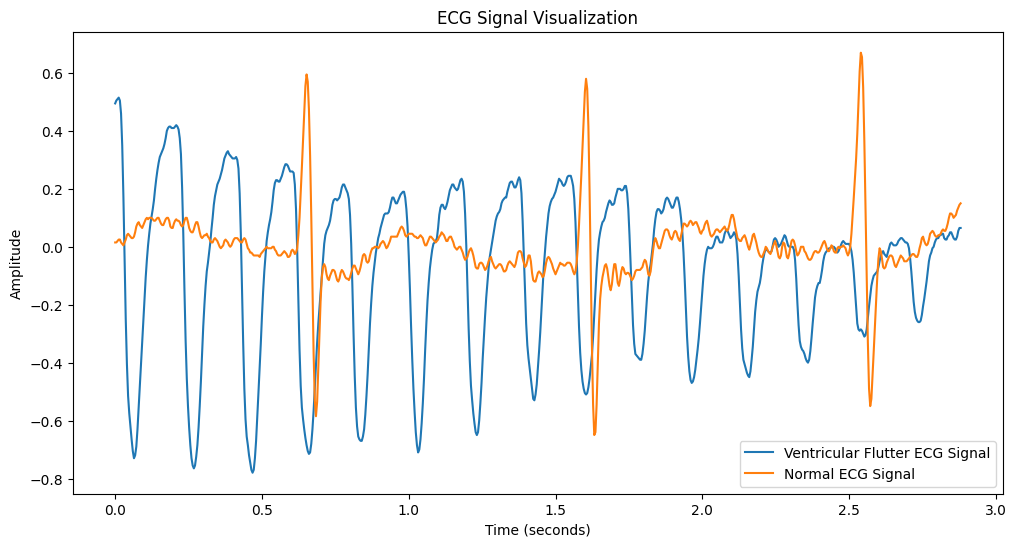

In [5]:
time_axis = [i / sample_rate for i in range(len(signal_data))]

# Plot the ECG signal (e.g., first channel)
plt.figure(figsize=(12, 6))  # Adjust plot size if needed
plt.plot(time_axis, signal_data[:, 0], label="Ventricular Flutter ECG Signal")  # Plot the first channel
plt.plot(time_axis, signal_data_normal[:, 0], label="Normal ECG Signal")  # Plot the first channel
#plt.plot(time_axis, signal_data_normal[:, 0], label="ECG Signal")
plt.title("ECG Signal Visualization")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()  # Display the plot

## Extraction and Labeling of ECG Signal Data for Classification

- Iterate through each ECG signal by its parent and child path.
- Label each ECG signal as Ventricular Flutter/Fibrillation (`VFL_VF = 1`) or not (`VFL_VF = 0`) based on its directory.
- Select and process only `.dat` files to prevent duplications and handle relevant formats.
- Use `wfdb.rdrecord` to read signals, flatten them to 1D.
- Add relevant metadata like file names and classification labels.
- Merge all DataFrames into one.
- Prepare the DataFrame for machine le
rning.

In [6]:
def get_signal_df(parent_path):

    """
    Collect, process, and organize ECG signal data from multiple file paths into a structured pandas DataFrame.

    Parameters:
    - parent_path (list): List containting the child paths.

    Returns:
    - pandas.DataFrame: Structured pandas DataFrame of the ECG signals.
    
    """
    
    signal_data_combined = []
    for child_path in parent_path:
    # creating classifier value VFL_VF = 1 for Ventricular Flutter or Fibrillation and VFL_VF = 0 if not
        if child_path == parent_path[0]:
            VFL_VF = 1
        else:
            VFL_VF = 0
        for frag in os.listdir(child_path):
            frag_ext = os.path.splitext(frag)[1]
        
            # accessing only .dat file to nuliffy duplications
            if frag_ext == '.dat':
            
                # removing file extantion to be able to read it with wfdb
                frag = os.path.splitext(frag)[0]
            
                # reading frag using it's path (eg. ../data/1_Dangerous_VFL_VF/frag/418_C_VFL_277s_frag)
                record = wfdb.rdrecord(os.path.join(child_path, frag))
            
                # get signal data and convert it from 2D to 1D
                signal_data = record.p_signal.flatten()
            
                # create data frame and rotate it horizontally
                signal_data = pd.DataFrame(signal_data).transpose()
            
                # adding metadata of the frag
                signal_data["frag"] = frag
                signal_data["VFL_VF"] = VFL_VF
            
                # adding signal data to the combined list
                signal_data_combined.append(signal_data)
            
    signal_data_combined = pd.concat(signal_data_combined, ignore_index=True)
    return signal_data_combined
    

        

df_signal = get_signal_df(paths)
df_signal

,0,1,2,3,4,5,6,7,8,9,...,713,714,715,716,717,718,719,720,frag,VFL_VF
0,0.900,0.890,0.875,0.860,0.855,0.865,0.875,0.870,0.840,0.780,...,0.990,1.010,1.020,1.010,0.995,0.970,0.955,0.940,418_C_VFL_1075s_frag,1
1,-0.955,-0.955,-0.960,-0.975,-1.000,-1.020,-1.010,-0.985,-0.945,-0.895,...,0.880,0.785,0.680,0.545,0.390,0.225,0.055,-0.100,418_C_VFL_277s_frag,1
2,-0.100,-0.240,-0.345,-0.430,-0.495,-0.550,-0.600,-0.650,-0.695,-0.745,...,-0.015,-0.145,-0.295,-0.445,-0.575,-0.675,-0.745,-0.790,418_C_VFL_279s_frag,1
3,0.445,0.495,0.535,0.560,0.585,0.605,0.630,0.660,0.685,0.710,...,-1.045,-1.055,-1.065,-1.080,-1.085,-1.080,-1.070,-1.055,418_C_VFL_370s_frag,1
4,1.085,1.120,1.135,1.140,1.145,1.150,1.160,1.170,1.175,1.175,...,0.665,0.635,0.605,0.575,0.550,0.520,0.480,0.440,418_C_VFL_377_6s_frag,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,-0.145,-0.150,-0.150,-0.150,-0.145,-0.140,-0.150,-0.165,-0.180,-0.175,...,0.130,0.135,0.130,0.110,0.085,0.060,0.025,0.005,612_C_N_350s_frag,0
1012,-0.375,-0.375,-0.370,-0.375,-0.380,-0.375,-0.365,-0.355,-0.340,-0.330,...,-0.005,0.015,0.020,0.025,0.015,0.005,0.005,0.015,612_C_N_570s_frag,0
1013,-0.365,-0.375,-0.365,-0.350,-0.345,-0.355,-0.360,-0.365,-0.365,-0.360,...,0.180,0.170,0.175,0.180,0.185,0.175,0.155,0.145,612_C_N_70s_frag,0
1014,0.080,0.095,0.125,0.135,0.135,0.120,0.105,0.095,0.100,0.105,...,-0.115,-0.105,-0.100,-0.095,-0.090,-0.085,-0.090,-0.095,614_C_N_933_8s_frag,0


## Deep Convolutional Neural Network for ECG Signal Classification

Setting up and running a Convolutional Neural Network (CNN) for the binary classification of the ECG signals:

- Setting up a multi-layer CNN and configuring the model 
- Using a callback to save the best model and use it for more training 
- Splitting the dataset into training, validation, and test sets to evaluate the model's performance
- Training the model using the specified data splits and recording the training history to monitor changes in performance over epochs.
- Evaluating the model's loss and accuracy.
- Predict classifications on new data

In [7]:
# Define the CNN model architecture
model = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(721, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback to save the best model
checkpoint_callback = callbacks.ModelCheckpoint(
    'best_model.keras',  # Path where the model will be saved
    monitor='val_accuracy',  # Monitor validation accuracy to determine the best model
    save_best_only=True,  # Save only when the 'val_accuracy' has improved
    mode='max',  # Save the model that has max validation accuracy
    verbose=1  # Print out messages when saving the model
)



# Splitting dataset into training, validation, and test sets
X = df_signal.iloc[:,:-2]
Y = df_signal.iloc[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Train the model with the callbacks
history = model.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint_callback]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test Accuracy: {test_accuracy}')

predictions = model.predict(X_test)

C:\Users\abdallah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6226 - loss: 1.2302
Epoch 1: val_accuracy improved from -inf to 0.31496, saving model to best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.6250 - loss: 1.2254 - val_accuracy: 0.3150 - val_loss: 1.2041
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8145 - loss: 0.7251
Epoch 2: val_accuracy did not improve from 0.31496
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8146 - loss: 0.7229 - val_accuracy: 0.2992 - val_loss: 1.0458
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8593 - loss: 0.4818
Epoch 3: val_accuracy improved from 0.31496 to 0.66142, saving model to best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8603 - loss: 0.4767 - val_accuracy: 0.6614 - val_loss: 0.6731
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9114 - loss: 0.3406
Epoch 4: val_accuracy improved from 0.66142 to 0.70079, saving model to best_model.ker

## Performance Evaluation of the ECG Classification Model

- Using the model to generate binary predictions from test data probabilities.
- Printing precision, recall, F1-score, and AUC-ROC for evaluation.

In [8]:
# Ensure your predictions are in the correct format
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate Precision, Recall, F1-Score, and AUC-ROC
print(classification_report(Y_test, predictions))

# Calculate AUC-ROC
roc_auc = roc_auc_score(Y_test, predictions)
print(f"AUC-ROC: {roc_auc}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        78
           1       0.87      0.92      0.89        49

    accuracy                           0.91       127
   macro avg       0.91      0.91      0.91       127
weighted avg       0.92      0.91      0.91       127

AUC-ROC: 0.9143118785975928


- Calculating a confusion matrix and display the matrix as a heatmap

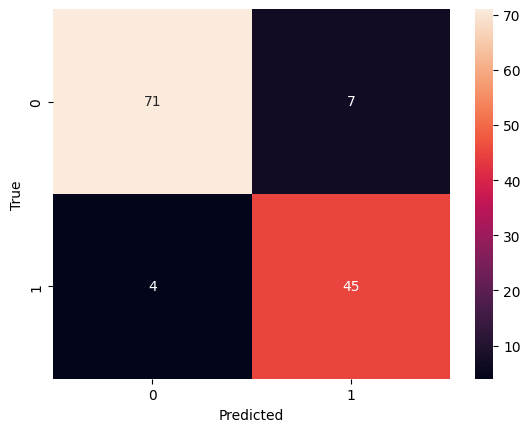

In [9]:
# Calculate confusion matrix
cm = confusion_matrix(Y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

- Computing the Receiver Operating Characteristic (ROC) curve using the test data and plotting it

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


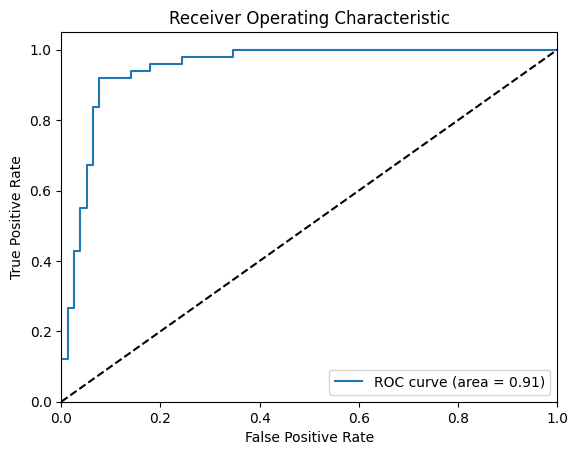

In [10]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(Y_test, model.predict(X_test))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

- Visualizing Model Accuracy and Loss Across Training Epochs

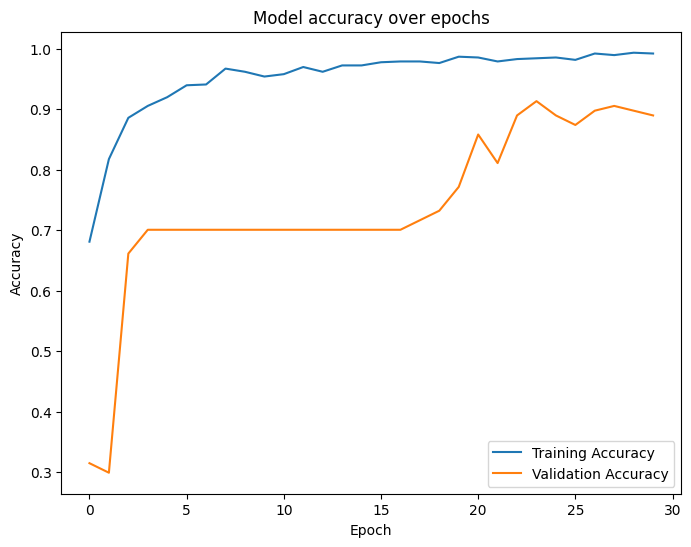

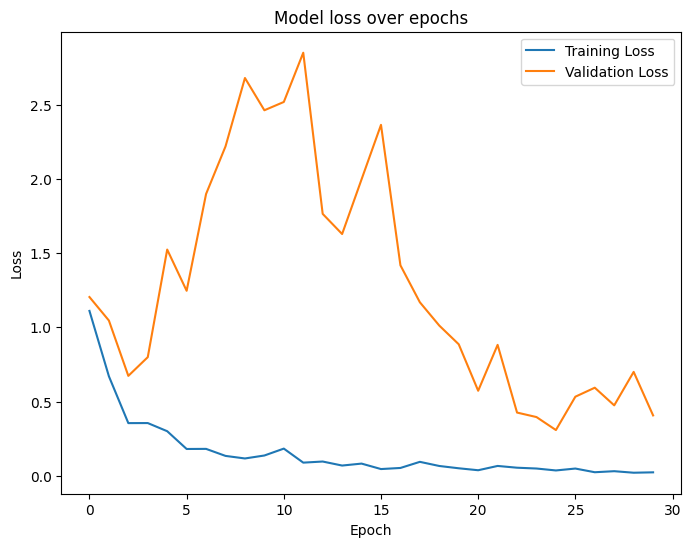

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.913385808467865
